# Generating 100,000 FSPS Spectra with Diverse SFHs

Goal is to get a more thoroughly sampled manifold, with more diverse star formation histories spanning a wider range of mean ages...

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fsps
from astroML.plotting import setup_text_plots
import h5py

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=24)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('font', size=24, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=13)
mpl.rc('axes', labelweight='black')

#### Allow sf_begin, fburst, tburst, tau, z, dust2 to vary -- age will be weighted average of ages of different components. For metallicity, must choose randint between 0 and 22. sf_begin, fburst, tau distributed logarithmically; z, bust2, tburst uniform

In [49]:
# get 100,000 samples
size=100000

#sf_begin = np.random.uniform(low=0.0, high=12.2, size=size)
logsf_begins = np.random.uniform(low=np.log10(0.1), high=np.log10(12.2), size=size)
sf_begins = 10**logsf_begin
As = 13.7 - sf_begin

tbursts = np.array([])
for ii in range(size):
    tbursts = np.append(tbursts, np.random.uniform(low=sf_begins[ii], high=13.7))

logfbursts = np.random.uniform(low=np.log10(0.03), high=np.log10(0.8), size=size)
fbursts = 10**logfburst

#taus = np.random.uniform(low=1.0, high=100, size=size) # this resulted in WAY too few old galaxies...
logtaus = np.random.uniform(low=-0.5, high=1.5, size=size)
taus = 10**logtaus
tau_ages = As - taus * ( (1. - (As/taus + 1.) * np.exp(-As/taus)) / (1. - np.exp(-As/taus)) ) # mean ages given taus

total_ages = (1-fburst) * tau_ages + fburst * (13.7 - tburst)

dusts = np.random.uniform(low=0.0, high=1.2, size=size)

#sigmas = np.random.uniform(low=0.0, high=300.0, size=size)

In [50]:
# do metallicity separately b/c need to choose integer for each model -- logz_values copied from FSPS manual
logz_values = np.array([-1.98, -1.80, -1.68, -1.58, -1.50, -1.38, -1.28, -1.20, -1.07, -0.98, -0.89, -0.79, \
                        -0.69, -0.59, -0.49, -0.39, -0.30, -0.20, -0.10, 0.0, 0.10, 0.20])

znums = np.random.randint(low=1, high=23, size=size) #want values from 1-22; high is exclusive
zinds = znums - 1 #b/c the znum starts at 1, not 0... ugh
zs = logz_values[zinds]

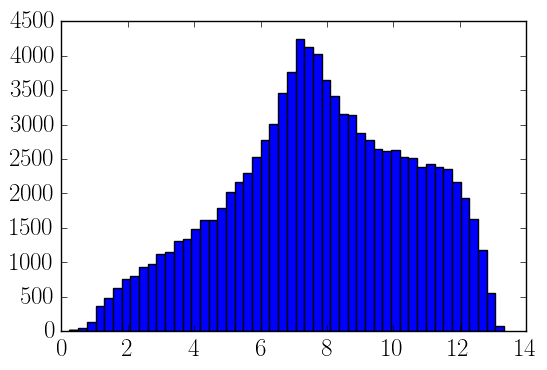

In [51]:
n, bins, patches = plt.hist(total_ages, bins=50)

#### now build the model spectra

In [75]:
spectra = np.zeros((size, 4220)) #know there are 4220 steps in desired wavelength range
mags = np.zeros((size, 5)) # save mags in 5 SDSS filters
bands = fsps.find_filter('sdss') # u, g, i, r, z (NOTE SILLY ORDERING)
ii = 0

for sf_begin, tburst, fburst, tau, dust, znum  in zip(sf_begins, tbursts, fbursts, taus, dusts, znums):
    sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=1, sigma_smooth=100., dust_type=2,
                                add_neb_emission=False, sf_start=sf_begin, tburst=tburst, fburst=fburst,
                                tau=tau, dust2=dust, zmet=znum)
    wave, spec = sp.get_spectrum(tage=(13.7 - sf_begin), peraa=True)
    wh = (wave < 7400.) * (wave > 3600.)
    spectra[ii, :] = spec[wh]
    mags[ii, :] = sp.get_mags(bands=fsps.find_filter('sdss'), tage=tage=(13.7 - sf_begin))
    ii += 1
    if ii%500 == 0:
        percent = ii/100
        print "%d percent complete" % percent

5 percent complete
10 percent complete
15 percent complete
20 percent complete
25 percent complete
30 percent complete
35 percent complete
40 percent complete
45 percent complete
50 percent complete
55 percent complete
60 percent complete
65 percent complete
70 percent complete
75 percent complete
80 percent complete
85 percent complete
90 percent complete
95 percent complete
100 percent complete


#### normalize the spectra

In [76]:
norms = spectra.shape[1] / np.sum(spectra, axis=1)
spectra_norm = spectra * norms[:,np.newaxis]

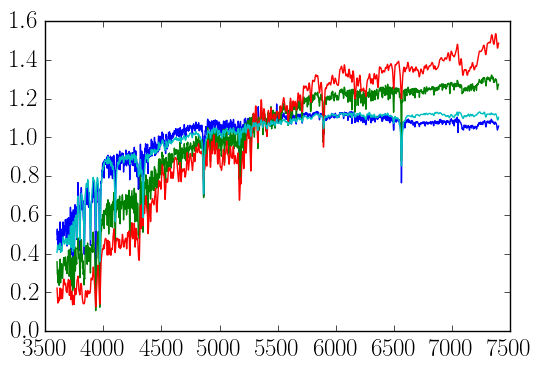

In [77]:
# quick sanity check
plt.figure()
plt.plot(wave[wh], spectra_norm[100])
plt.plot(wave[wh], spectra_norm[1009])
plt.plot(wave[wh], spectra_norm[6095])
plt.plot(wave[wh], spectra_norm[9998])
plt.plot(wave[wh], spectra_norm[50628])
plt.plot(wave[wh], spectra_norm[82534])

#### save spectra and parameters to HDF5 file

In [78]:
f = h5py.File('../data/1e5_spectra_diverseSFH.hdf5','w')
f.create_dataset('spectra', data=spectra_norm)
f.create_dataset('wave', data=wave[wh])
f.create_dataset('sdss_mags', data=mags)
f.create_dataset('sf_begins', data=sf_begins)
f.create_dataset('tbursts', data=tbursts)
f.create_dataset('fbursts', data=fbursts)
f.create_dataset('taus', data=taus)
f.create_dataset('mean_ages', data=total_ages)
f.create_dataset('znums', data=znums)
f.create_dataset('zs', data=zs)
f.create_dataset('dusts', data=dusts)

<HDF5 dataset "sigmas": shape (10000,), type "<f8">

In [79]:
f.keys()

[u'ages', u'dusts', u'sigmas', u'spectra', u'taus', u'wave', u'znums', u'zs']

In [80]:
f['spectra'].shape

(10000, 4220)

In [81]:
f.close()